<a href="https://colab.research.google.com/github/truongdx5/KGCN/blob/master/GraphSage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

In [ ]:
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [ ]:
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 2.6 MB/s 


In [ ]:
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 2.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 926 kB 2.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 382 kB 2.6 MB/s 
     |████████████████████████████████| 222 kB 5.3 MB/s 
     |████████████████████████████████| 376 kB 43.2 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388143 sha256=ec105384e2af72e06c2693a479a8f1319a3d09d5e355fb5ac708c176b850aa66
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric


In [ ]:
from torch_geometric.datasets import Planetoid
import torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

In [ ]:
#dataset_cora = Planetoid(root='./cora/', name='Cora')
#dataset_cora = Planetoid(root='./citeseer',name='Citeseer')
dataset_cora = Planetoid(root='./pubmed/',name='Pubmed')
print(dataset_cora)

Processing...
Done!
Pubmed()


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(dataset_cora.num_node_features, 16)
        self.conv2 = SAGEConv(16, dataset_cora.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.softmax(x, dim=1)

        return x

In [ ]:
model = Net()
print(model)

Net(
  (conv1): SAGEConv(500, 16)
  (conv2): SAGEConv(16, 3)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
data = dataset_cora[0].to(device)
print(data)

cpu
Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
Epoch = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []


model.train()
for epoch in range(380):
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss_val = criterion(out[data.val_mask], data.y[data.val_mask])
    loss_total = loss.add(loss_val)

    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()

    _, pred = torch.max(out[data.train_mask], dim=1)
    correct = (pred == data.y[data.train_mask]).sum().item()
    acc = correct/data.train_mask.sum().item()

    _, pred_val = torch.max(out[data.val_mask], dim=1)
    correct_val = (pred_val == data.y[data.val_mask]).sum().item()
    acc_val = correct_val/data.val_mask.sum().item()
    train_loss.append(loss.item())
    train_acc.append(acc)
    val_loss.append(loss_val.item())
    val_acc.append(acc_val)
    Epoch.append(epoch)

    print('Epoch {:03d} train_loss: {:.4f} train_acc: {:.4f}  val_loss: {:.4f} val_acc: {:.4f}'.format( epoch, loss.item(), acc,loss_val.item(), acc_val))

Epoch 000 train_loss: 1.0992 train_acc: 0.3333  val_loss: 1.1020 val_acc: 0.1960
Epoch 001 train_loss: 1.0963 train_acc: 0.4500  val_loss: 1.0968 val_acc: 0.4580
Epoch 002 train_loss: 1.0908 train_acc: 0.5333  val_loss: 1.0919 val_acc: 0.5300
Epoch 003 train_loss: 1.0844 train_acc: 0.6167  val_loss: 1.0852 val_acc: 0.5500
Epoch 004 train_loss: 1.0740 train_acc: 0.7000  val_loss: 1.0760 val_acc: 0.6180
Epoch 005 train_loss: 1.0681 train_acc: 0.6667  val_loss: 1.0681 val_acc: 0.6080
Epoch 006 train_loss: 1.0482 train_acc: 0.7667  val_loss: 1.0575 val_acc: 0.6380
Epoch 007 train_loss: 1.0458 train_acc: 0.6500  val_loss: 1.0497 val_acc: 0.6340
Epoch 008 train_loss: 1.0320 train_acc: 0.7500  val_loss: 1.0400 val_acc: 0.6600
Epoch 009 train_loss: 1.0317 train_acc: 0.7000  val_loss: 1.0295 val_acc: 0.6600
Epoch 010 train_loss: 1.0112 train_acc: 0.7333  val_loss: 1.0206 val_acc: 0.6520
Epoch 011 train_loss: 0.9899 train_acc: 0.8500  val_loss: 1.0093 val_acc: 0.6600
Epoch 012 train_loss: 0.9704

**Dataset 4**

In [ ]:
model.eval()
out = model(data)
loss = criterion(out[data.test_mask], data.y[data.test_mask])
_, pred = torch.max(out[data.test_mask], dim=1)
correct = (pred == data.y[data.test_mask]).sum().item()
acc = correct/data.test_mask.sum().item()
print("test_loss: {:.5f} test_acc: {:.5f}".format(loss.item(), acc))

test_loss: 1.32394 test_acc: 0.84600


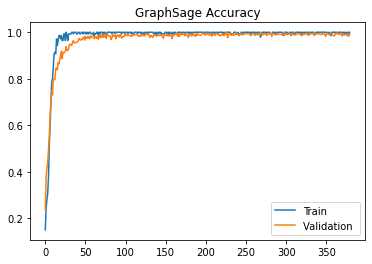

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_acc, Epoch, val_acc)
plt.title('GraphSage Accuracy')
plt.legend(['Train','Validation '])
plt.show()

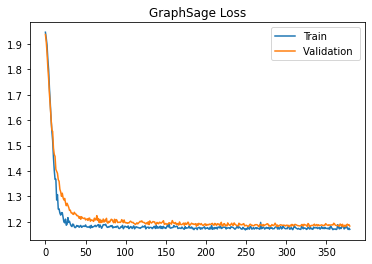

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_loss, Epoch, val_loss)
plt.title('GraphSage Loss')
plt.legend(['Train','Validation '])
plt.show()

Dataset 1

In [ ]:
model.eval()
out = model(data)
loss = criterion(out[data.test_mask], data.y[data.test_mask])
_, pred = torch.max(out[data.test_mask], dim=1)
correct = (pred == data.y[data.test_mask]).sum().item()
acc = correct/data.test_mask.sum().item()
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.3141 test_acc: 0.7300


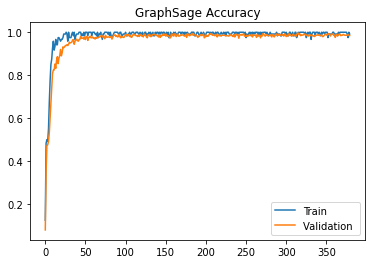

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_acc, Epoch, val_acc)
plt.title('GraphSage Accuracy')
plt.legend(['Train','Validation '])
plt.show()

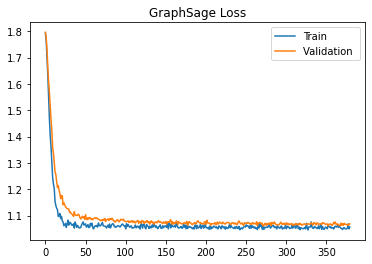

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_loss, Epoch, val_loss)
plt.title('GraphSage Loss')
plt.legend(['Train','Validation '])
plt.show()

In [ ]:
Dataset 3

In [ ]:
model.eval()
out = model(data)
loss = criterion(out[data.test_mask], data.y[data.test_mask])
_, pred = torch.max(out[data.test_mask], dim=1)
correct = (pred == data.y[data.test_mask]).sum().item()
acc = correct/data.test_mask.sum().item()
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 0.7328 test_acc: 0.8230


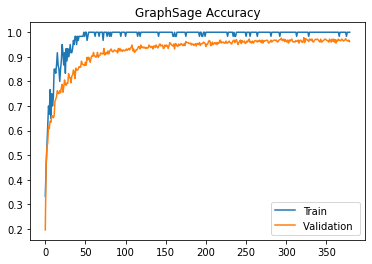

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_acc, Epoch, val_acc)
plt.title('GraphSage Accuracy')
plt.legend(['Train','Validation '])
plt.show()

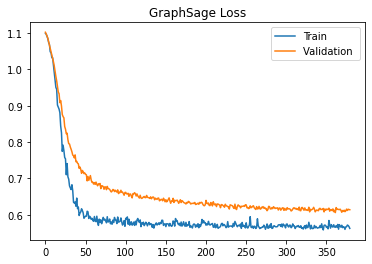

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_loss, Epoch, val_loss)
plt.title('GraphSage Loss')
plt.legend(['Train','Validation '])
plt.show()

Dataset 2

In [ ]:
 train_acc4 = train_acc
 val_acc4 = val_acc

In [ ]:
train_loss4 = train_loss
val_loss4 = val_loss

In [ ]:
import csv
csvFile = open('datadraw.csv', 'w', encoding = "utf-8")
row = ['Epoch', 'acc_train', 'acc_val','cost_train','cost_val']
writer = csv.writer(csvFile)
writer.writerow(row)
for i in range(len(Epoch)):
    row = [Epoch[i], train_acc4[i], val_acc4[i],train_loss4[i],val_loss4[i]]
    writer.writerow(row)
csvFile.close()

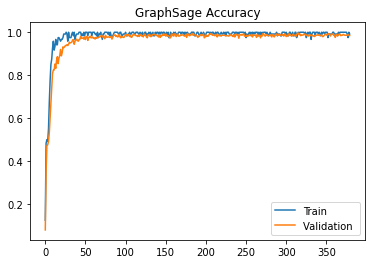

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_acc4, Epoch, val_acc4)
plt.title('GraphSage Accuracy')
plt.legend(['Train','Validation '])
plt.show()

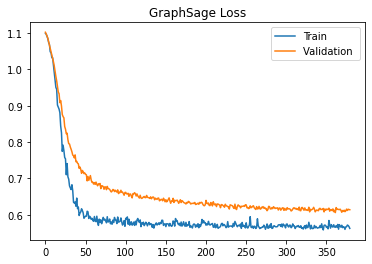

In [ ]:
from matplotlib import pyplot as plt

plt.plot(Epoch, train_loss4, Epoch, val_loss4)
plt.title('GraphSage Loss')
plt.legend(['Train','Validation '])
plt.show()